In [1]:
!pip -q install --upgrade --no-warn-script-location ultralytics albumentations pycocotools torchmetrics tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Data split into labeled and unlabeled sets successfully.
YAML files created for teacher and student training.
Ultralytics 8.3.187 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/fish_teacher_student/data_teacher.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscri

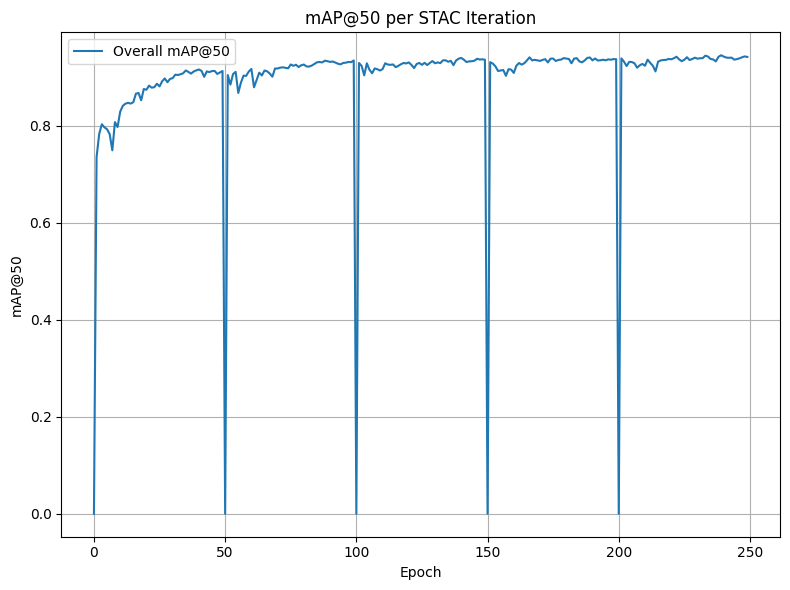

Visualizing predictions for image: 80_white_high_5dead_42.jpg

image 1/1 /kaggle/working/fish_teacher_student/0_yolo_split/test/images/80_white_high_5dead_42.jpg: 640x384 73 fishs, 6 dead_fishs, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


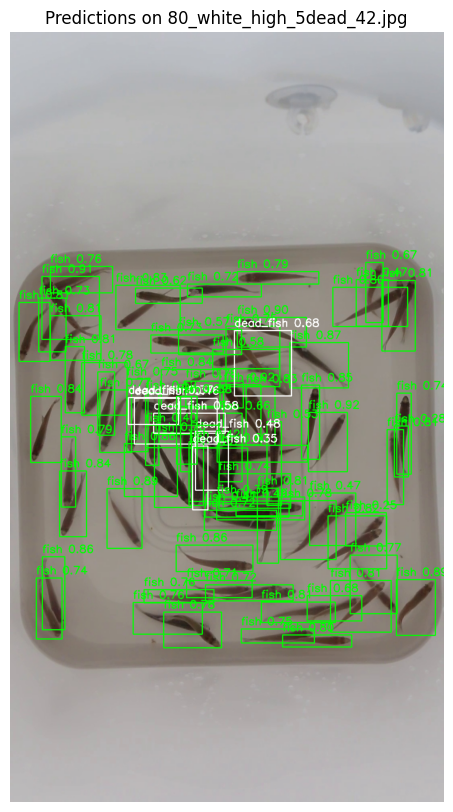

In [2]:
import pandas as pd
import json
import shutil
import random
import warnings
import yaml
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Define base paths
BASE = Path("/kaggle/input/fish-yolo/Fish Fry Dataset")
TRAIN_IMG = BASE / "train"
TRAIN_JSON = BASE / "annotations/instances_train.json"
VALID_IMG = BASE / "validation"
VALID_JSON = BASE / "annotations/instances_val.json"

# Working directories
WORK = Path("/kaggle/working/fish_teacher_student")
SPLIT = WORK / "0_yolo_split"
PSEUDO = WORK / "1_pseudo"
STU_ROOT = WORK / "2_student"

# Create necessary directories
for split in ["train_labeled", "train_unlabeled", "valid", "test"]:
    (SPLIT / split / "images").mkdir(parents=True, exist_ok=True)
    (SPLIT / split / "labels").mkdir(parents=True, exist_ok=True)
(PSEUDO / "raw" / "labels").mkdir(parents=True, exist_ok=True)
for sub in ["train", "valid"]:
    (STU_ROOT / sub / "images").mkdir(parents=True, exist_ok=True)
    (STU_ROOT / "valid" / "labels").mkdir(parents=True, exist_ok=True)
    (STU_ROOT / "train" / "labels").mkdir(parents=True, exist_ok=True)

# --- Step 1: Correctly split and prepare the labeled and unlabeled data ---
def coco2yolo(b, w, h):
    x, y, ww, hh = b
    return (x + ww / 2) / w, (y + hh / 2) / h, ww / w, hh / h

def convert_annotations(annotations, img_dir, output_dir):
    """Converts COCO JSON annotations to YOLO format .txt files for a set of images."""
    id2img = {img["id"]: img for img in annotations["images"]}
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for ann in annotations["annotations"]:
        img = id2img[ann["image_id"]]
        w, h = img["width"], img["height"]
        yb = coco2yolo(ann["bbox"], w, h)
        cls = ann["category_id"] - 1
        label_path = output_dir / f"{Path(img['file_name']).stem}.txt"
        with open(label_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

def split_and_copy_data(img_dir, ann_json_path, labeled_ratio=0.2):
    """Splits images into labeled and unlabeled sets and copies them with labels."""
    with open(ann_json_path, 'r') as f:
        full_annotations = json.load(f)
    
    all_images = full_annotations['images']
    random.shuffle(all_images)
    
    num_labeled = int(len(all_images) * labeled_ratio)
    labeled_images = all_images[:num_labeled]
    unlabeled_images = all_images[num_labeled:]

    # Create filtered annotation sets
    labeled_image_ids = {img['id'] for img in labeled_images}
    labeled_annotations = full_annotations.copy()
    labeled_annotations['images'] = labeled_images
    labeled_annotations['annotations'] = [ann for ann in full_annotations['annotations'] if ann['image_id'] in labeled_image_ids]

    unlabeled_image_ids = {img['id'] for img in unlabeled_images}
    unlabeled_annotations = full_annotations.copy()
    unlabeled_annotations['images'] = unlabeled_images
    unlabeled_annotations['annotations'] = [ann for ann in full_annotations['annotations'] if ann['image_id'] in unlabeled_image_ids]
    
    # Copy labeled images and create their YOLO labels
    for img in labeled_images:
        shutil.copy(img_dir / img['file_name'], SPLIT / "train_labeled" / "images")
    convert_annotations(labeled_annotations, img_dir, SPLIT / "train_labeled" / "labels")
    
    # Copy unlabeled images without creating labels
    for img in unlabeled_images:
        shutil.copy(img_dir / img['file_name'], SPLIT / "train_unlabeled" / "images")

# Execute data splitting for the training data
split_and_copy_data(TRAIN_IMG, TRAIN_JSON)

# Copy validation data
shutil.copytree(VALID_IMG, SPLIT / "valid" / "images", dirs_exist_ok=True)
convert_annotations(json.load(open(VALID_JSON)), VALID_IMG, SPLIT / "valid" / "labels")
print("Data split into labeled and unlabeled sets successfully.")

# --- Step 2: YAML Configuration ---
with open(TRAIN_JSON, 'r') as f:
    annotations = json.load(f)
cats = annotations["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
nc = len(names)
data_teacher_yaml = {
    'path': str(SPLIT),
    'train': 'train_labeled/images',
    'val': 'valid/images',
    'nc': nc,
    'names': names}
with open(WORK / "data_teacher.yaml", 'w') as f:
    yaml.dump(data_teacher_yaml, f)
data_student_yaml = {
    'path': str(STU_ROOT),
    'train': 'train/images', # This will be the merged dataset
    'val': 'valid/images',
    'nc': nc,
    'names': names}
with open(WORK / "data_student.yaml", 'w') as f:
    yaml.dump(data_student_yaml, f)
print("YAML files created for teacher and student training.")

# --- Step 3: Initial Teacher Training on Labeled Data (20%) ---
teacher = YOLO("yolo11n.pt")
teacher.train(
    data=str(WORK / "data_teacher.yaml"),
    epochs=50,
    imgsz=640,
    batch=8,
    project=str(WORK),
    name="teacher",
    device=0)
teacher_weights = WORK / "teacher" / "weights" / "best.pt"
print(f"Teacher model trained successfully. Weights saved at: {teacher_weights}")

# --- Step 4: STAC-style self-training loop ---
IMGZ = 640
TAU = 0.7
STAC_ITERS = 5
STU_EPOCHS = 50
BATCH = 8

# Populate student's validation data once
shutil.copytree(SPLIT / "valid" / "images", STU_ROOT / "valid" / "images", dirs_exist_ok=True)
shutil.copytree(SPLIT / "valid" / "labels", STU_ROOT / "valid" / "labels", dirs_exist_ok=True)

# Store metrics to plot later
all_metrics = {
    "val_mAP50": [],
}

for it in range(STAC_ITERS):
    print(f"\n=== STAC iteration {it + 1}/{STAC_ITERS} ===")

    # Generate pseudo-labels on unlabeled images
    _ = YOLO(str(teacher_weights)).predict(
        source=str(SPLIT / "train_unlabeled" / "images"),
        save_txt=True,
        save_conf=True,
        conf=TAU,
        project=str(PSEUDO),
        name=f"it{it}",
        device=0
    )

    raw_pseudo_labels = PSEUDO / f"it{it}" / "labels"

    # Merge Ground Truth (GT) and pseudo-labels into student train dataset
    shutil.rmtree(STU_ROOT / "train", ignore_errors=True)
    (STU_ROOT / "train" / "images").mkdir(parents=True, exist_ok=True)
    (STU_ROOT / "train" / "labels").mkdir(parents=True, exist_ok=True)
    
    # Copy all training images (both labeled and unlabeled) to student's training folder
    for im in (SPLIT / "train_labeled" / "images").glob("*.jpg"):
        shutil.copy(im, STU_ROOT / "train" / "images")
    for im in (SPLIT / "train_unlabeled" / "images").glob("*.jpg"):
        shutil.copy(im, STU_ROOT / "train" / "images")

    # Copy GT labels for the 20% labeled data
    for gt in (SPLIT / "train_labeled" / "labels").glob("*.txt"):
        shutil.copy(gt, STU_ROOT / "train" / "labels")
    
    # Copy pseudo-labels for the 80% unlabeled data
    for pseudo_lbl in raw_pseudo_labels.glob("*.txt"):
        shutil.copy(pseudo_lbl, STU_ROOT / "train" / "labels")

    # Train the student model
    student = YOLO(str(teacher_weights))
    
    # Add callbacks to log metrics per epoch
    def on_train_epoch_end(trainer):
        # Access validation mAP50.
        if "metrics/mAP50(B)" in trainer.metrics:
            all_metrics["val_mAP50"].append(trainer.metrics["metrics/mAP50(B)"])
        else:
            all_metrics["val_mAP50"].append(0.0)
    
    student.add_callback("on_train_epoch_end", on_train_epoch_end)

    student.train(
        data=str(WORK / "data_student.yaml"),
        epochs=STU_EPOCHS,
        imgsz=IMGZ,
        batch=BATCH,
        project=str(WORK),
        name=f"student_it{it}",
        device=0
    )
    
    # Promote the best student to be the new teacher
    teacher_weights = WORK / f"student_it{it}" / "weights" / "best.pt"
    print(f"Promoted student to teacher for iteration {it+1}.")

# --- Step 5: Final Evaluation and Visualization ---
student_model_path = WORK / f"student_it{STAC_ITERS - 1}" / "weights" / "best.pt"
final_student_model = YOLO(student_model_path)
metrics = final_student_model.val(
    data=str(WORK / "data_student.yaml"),
    imgsz=640,
    batch=8,
    device=0,
    plots=False)

print("Final student model metrics:", metrics)

# Plotting the training curves
plt.figure(figsize=(8, 6))

# Plot mAP@50
plt.plot(all_metrics["val_mAP50"], label='Overall mAP@50')
plt.title('mAP@50 per STAC Iteration')
plt.xlabel('Epoch')
plt.ylabel('mAP@50')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

def visualize_predictions(model, img_dir, names):
    """
    Visualize a random image from the test set with model predictions, 
    using different colors for different classes.
    """
    image_paths = list(img_dir.glob("*.jpg"))
    if not image_paths:
        print("No images found for visualization.")
        return

    random_image_path = random.choice(image_paths)
    print(f"Visualizing predictions for image: {random_image_path.name}")

    # Run inference
    results = model.predict(source=str(random_image_path), save=False, conf=0.25, iou=0.5)

    # Load and process image
    img = cv2.imread(str(random_image_path))
    # Convert BGR to RGB for correct display with Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Define a dictionary mapping class names to colors directly
    class_colors = {
        'fish': (0, 255, 0),  # Green for fish
        'dead': (255, 0, 0),  # Red for dead (Corrected from yellow)
    }

    # Draw bounding boxes and labels
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0]
            cls = int(box.cls[0])
            label = f"{names[cls]} {conf:.2f}"
            
            # Get the color based on the class name
            color = class_colors.get(names[cls], (255, 255, 255))
            
            # Draw box
            # Note: OpenCV uses BGR, so you need to convert the color tuple.
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
            # Draw label
            cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(f"Predictions on {random_image_path.name}")
    plt.axis('off')
    plt.show()
# Create a test directory and copy some images for visualization
test_dir = SPLIT / "test" / "images"
test_dir.mkdir(parents=True, exist_ok=True)
test_images_to_copy = random.sample(list(VALID_IMG.glob("*.jpg")), 5)
for img_path in test_images_to_copy:
    shutil.copy(img_path, test_dir)

# Visualize a random test image
visualize_predictions(final_student_model, test_dir, names)